<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:12:55] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


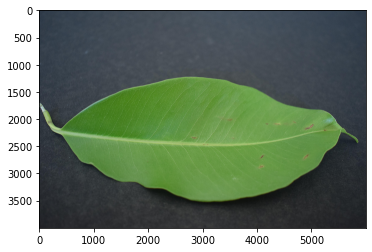

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

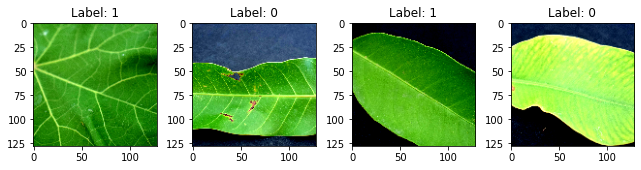

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:13:02] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:13:04] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2569102955038447 samples/sec                   batch loss = 1.2781833410263062 | accuracy = 0.2


Epoch[1] Batch[10] Speed: 1.271892596849504 samples/sec                   batch loss = 1.5824432373046875 | accuracy = 0.375


Epoch[1] Batch[15] Speed: 1.2468766057686604 samples/sec                   batch loss = 0.35866424441337585 | accuracy = 0.5


Epoch[1] Batch[20] Speed: 1.2637974707954454 samples/sec                   batch loss = 0.7479037046432495 | accuracy = 0.525


Epoch[1] Batch[25] Speed: 1.2655123399630632 samples/sec                   batch loss = 0.49414458870887756 | accuracy = 0.53


Epoch[1] Batch[30] Speed: 1.267790436795298 samples/sec                   batch loss = 0.9016009569168091 | accuracy = 0.5583333333333333


Epoch[1] Batch[35] Speed: 1.2703635281259573 samples/sec                   batch loss = 0.6209096312522888 | accuracy = 0.55


Epoch[1] Batch[40] Speed: 1.2696621033482716 samples/sec                   batch loss = 1.8595037460327148 | accuracy = 0.54375


Epoch[1] Batch[45] Speed: 1.272224378756879 samples/sec                   batch loss = 0.39239948987960815 | accuracy = 0.55


Epoch[1] Batch[50] Speed: 1.2686562164375106 samples/sec                   batch loss = 0.4037405550479889 | accuracy = 0.565


Epoch[1] Batch[55] Speed: 1.2787917665682083 samples/sec                   batch loss = 0.825792670249939 | accuracy = 0.5590909090909091


Epoch[1] Batch[60] Speed: 1.2665581835840258 samples/sec                   batch loss = 0.72095787525177 | accuracy = 0.5708333333333333


Epoch[1] Batch[65] Speed: 1.2724671521198703 samples/sec                   batch loss = 0.4050096273422241 | accuracy = 0.5807692307692308


Epoch[1] Batch[70] Speed: 1.2720297252467847 samples/sec                   batch loss = 0.5486139059066772 | accuracy = 0.5857142857142857


Epoch[1] Batch[75] Speed: 1.2682600409871694 samples/sec                   batch loss = 0.7761574983596802 | accuracy = 0.6033333333333334


Epoch[1] Batch[80] Speed: 1.2665480483732536 samples/sec                   batch loss = 0.7046306729316711 | accuracy = 0.603125


Epoch[1] Batch[85] Speed: 1.2696486515652794 samples/sec                   batch loss = 0.5971882939338684 | accuracy = 0.5970588235294118


Epoch[1] Batch[90] Speed: 1.2697583880020464 samples/sec                   batch loss = 0.7730116248130798 | accuracy = 0.5916666666666667


Epoch[1] Batch[95] Speed: 1.2687857392043242 samples/sec                   batch loss = 0.635349690914154 | accuracy = 0.5921052631578947


Epoch[1] Batch[100] Speed: 1.2735120569152438 samples/sec                   batch loss = 0.4114227294921875 | accuracy = 0.595


Epoch[1] Batch[105] Speed: 1.267543124016509 samples/sec                   batch loss = 0.4689180850982666 | accuracy = 0.6047619047619047


Epoch[1] Batch[110] Speed: 1.2720288572525562 samples/sec                   batch loss = 0.5739878416061401 | accuracy = 0.6045454545454545


Epoch[1] Batch[115] Speed: 1.268231663187648 samples/sec                   batch loss = 0.2824058532714844 | accuracy = 0.6021739130434782


Epoch[1] Batch[120] Speed: 1.2713112387028322 samples/sec                   batch loss = 0.5418789386749268 | accuracy = 0.6083333333333333


Epoch[1] Batch[125] Speed: 1.2696990972212814 samples/sec                   batch loss = 0.44069063663482666 | accuracy = 0.61


Epoch[1] Batch[130] Speed: 1.2656895350391644 samples/sec                   batch loss = 0.4096721112728119 | accuracy = 0.6096153846153847


Epoch[1] Batch[135] Speed: 1.2669801817610216 samples/sec                   batch loss = 0.4063206911087036 | accuracy = 0.6111111111111112


Epoch[1] Batch[140] Speed: 1.2661157319174634 samples/sec                   batch loss = 0.8173401951789856 | accuracy = 0.6178571428571429


Epoch[1] Batch[145] Speed: 1.2677609304340165 samples/sec                   batch loss = 0.9695441722869873 | accuracy = 0.6155172413793103


Epoch[1] Batch[150] Speed: 1.266467068128363 samples/sec                   batch loss = 0.5136153697967529 | accuracy = 0.6216666666666667


Epoch[1] Batch[155] Speed: 1.2627549440204917 samples/sec                   batch loss = 0.4480980634689331 | accuracy = 0.6161290322580645


Epoch[1] Batch[160] Speed: 1.2662839207938548 samples/sec                   batch loss = 0.41839250922203064 | accuracy = 0.6171875


Epoch[1] Batch[165] Speed: 1.2702783082839524 samples/sec                   batch loss = 0.3420494496822357 | accuracy = 0.6227272727272727


Epoch[1] Batch[170] Speed: 1.2706598666752098 samples/sec                   batch loss = 0.644126832485199 | accuracy = 0.6235294117647059


Epoch[1] Batch[175] Speed: 1.2662265786571152 samples/sec                   batch loss = 0.508052408695221 | accuracy = 0.6257142857142857


Epoch[1] Batch[180] Speed: 1.26550279422316 samples/sec                   batch loss = 0.49351584911346436 | accuracy = 0.625


Epoch[1] Batch[185] Speed: 1.259531082397512 samples/sec                   batch loss = 1.110246181488037 | accuracy = 0.6256756756756757


Epoch[1] Batch[190] Speed: 1.2650979011197372 samples/sec                   batch loss = 0.7556402087211609 | accuracy = 0.6263157894736842


Epoch[1] Batch[195] Speed: 1.256862367439136 samples/sec                   batch loss = 0.7982673048973083 | accuracy = 0.6256410256410256


Epoch[1] Batch[200] Speed: 1.2584649940156736 samples/sec                   batch loss = 1.0087604522705078 | accuracy = 0.6225


Epoch[1] Batch[205] Speed: 1.2602991716552396 samples/sec                   batch loss = 0.5655146837234497 | accuracy = 0.6231707317073171


Epoch[1] Batch[210] Speed: 1.2555245887923665 samples/sec                   batch loss = 0.7765480875968933 | accuracy = 0.6261904761904762


Epoch[1] Batch[215] Speed: 1.263484817516643 samples/sec                   batch loss = 0.3990691006183624 | accuracy = 0.627906976744186


Epoch[1] Batch[220] Speed: 1.2686920004543245 samples/sec                   batch loss = 0.6846758723258972 | accuracy = 0.6295454545454545


Epoch[1] Batch[225] Speed: 1.2635104140550977 samples/sec                   batch loss = 0.4463828206062317 | accuracy = 0.6311111111111111


Epoch[1] Batch[230] Speed: 1.2693343453377208 samples/sec                   batch loss = 0.6461359262466431 | accuracy = 0.6315217391304347


Epoch[1] Batch[235] Speed: 1.267639853775617 samples/sec                   batch loss = 0.3702002763748169 | accuracy = 0.6340425531914894


Epoch[1] Batch[240] Speed: 1.2649568267507216 samples/sec                   batch loss = 1.3386445045471191 | accuracy = 0.634375


Epoch[1] Batch[245] Speed: 1.2739897798130235 samples/sec                   batch loss = 0.41115033626556396 | accuracy = 0.6357142857142857


Epoch[1] Batch[250] Speed: 1.2664330346581656 samples/sec                   batch loss = 0.5292200446128845 | accuracy = 0.638


Epoch[1] Batch[255] Speed: 1.2706555360583345 samples/sec                   batch loss = 0.6039057970046997 | accuracy = 0.6392156862745098


Epoch[1] Batch[260] Speed: 1.271290141698871 samples/sec                   batch loss = 0.6989096999168396 | accuracy = 0.6403846153846153


Epoch[1] Batch[265] Speed: 1.2749794377349994 samples/sec                   batch loss = 0.549883246421814 | accuracy = 0.6415094339622641


Epoch[1] Batch[270] Speed: 1.2685438888456226 samples/sec                   batch loss = 0.5907621383666992 | accuracy = 0.6407407407407407


Epoch[1] Batch[275] Speed: 1.266079424274453 samples/sec                   batch loss = 0.7087538242340088 | accuracy = 0.6409090909090909


Epoch[1] Batch[280] Speed: 1.2750208118229698 samples/sec                   batch loss = 0.5999404191970825 | accuracy = 0.6446428571428572


Epoch[1] Batch[285] Speed: 1.2675089369297576 samples/sec                   batch loss = 0.8586182594299316 | accuracy = 0.6447368421052632


Epoch[1] Batch[290] Speed: 1.2758966924076036 samples/sec                   batch loss = 0.4773712158203125 | accuracy = 0.6456896551724138


Epoch[1] Batch[295] Speed: 1.2669533920150415 samples/sec                   batch loss = 0.6686122417449951 | accuracy = 0.6440677966101694


Epoch[1] Batch[300] Speed: 1.2652618120062502 samples/sec                   batch loss = 0.4591629207134247 | accuracy = 0.6458333333333334


Epoch[1] Batch[305] Speed: 1.2634917636866283 samples/sec                   batch loss = 0.7868528962135315 | accuracy = 0.6491803278688525


Epoch[1] Batch[310] Speed: 1.26366115968963 samples/sec                   batch loss = 0.7653413414955139 | accuracy = 0.6508064516129032


Epoch[1] Batch[315] Speed: 1.264346153730214 samples/sec                   batch loss = 0.8224121332168579 | accuracy = 0.6507936507936508


Epoch[1] Batch[320] Speed: 1.2605475485983022 samples/sec                   batch loss = 0.6219712495803833 | accuracy = 0.6484375


Epoch[1] Batch[325] Speed: 1.27004636816987 samples/sec                   batch loss = 0.5743438601493835 | accuracy = 0.6515384615384615


Epoch[1] Batch[330] Speed: 1.2612194994337853 samples/sec                   batch loss = 0.5245364308357239 | accuracy = 0.6515151515151515


Epoch[1] Batch[335] Speed: 1.264387507587207 samples/sec                   batch loss = 0.857553243637085 | accuracy = 0.6522388059701493


Epoch[1] Batch[340] Speed: 1.2702991793550458 samples/sec                   batch loss = 0.20300598442554474 | accuracy = 0.6551470588235294


Epoch[1] Batch[345] Speed: 1.2639157197465511 samples/sec                   batch loss = 0.3222774267196655 | accuracy = 0.6572463768115943


Epoch[1] Batch[350] Speed: 1.2682651222812724 samples/sec                   batch loss = 1.053377389907837 | accuracy = 0.6564285714285715


Epoch[1] Batch[355] Speed: 1.2593268704182319 samples/sec                   batch loss = 0.426466166973114 | accuracy = 0.6591549295774648


Epoch[1] Batch[360] Speed: 1.275574145432588 samples/sec                   batch loss = 0.4763883948326111 | accuracy = 0.6576388888888889


Epoch[1] Batch[365] Speed: 1.2651460777356913 samples/sec                   batch loss = 0.42574259638786316 | accuracy = 0.6595890410958904


Epoch[1] Batch[370] Speed: 1.26730950114107 samples/sec                   batch loss = 0.503846287727356 | accuracy = 0.6621621621621622


Epoch[1] Batch[375] Speed: 1.267542166369926 samples/sec                   batch loss = 0.6445620059967041 | accuracy = 0.6613333333333333


Epoch[1] Batch[380] Speed: 1.2629558960280822 samples/sec                   batch loss = 0.3089553415775299 | accuracy = 0.6625


Epoch[1] Batch[385] Speed: 1.2690444801284806 samples/sec                   batch loss = 0.48130086064338684 | accuracy = 0.6636363636363637


Epoch[1] Batch[390] Speed: 1.260662158838682 samples/sec                   batch loss = 0.3644556999206543 | accuracy = 0.666025641025641


Epoch[1] Batch[395] Speed: 1.2743337880578605 samples/sec                   batch loss = 0.39135023951530457 | accuracy = 0.6651898734177215


Epoch[1] Batch[400] Speed: 1.262056007725245 samples/sec                   batch loss = 0.8721241354942322 | accuracy = 0.66625


Epoch[1] Batch[405] Speed: 1.2667832079125627 samples/sec                   batch loss = 0.3831843435764313 | accuracy = 0.6685185185185185


Epoch[1] Batch[410] Speed: 1.2620392989630078 samples/sec                   batch loss = 0.29569950699806213 | accuracy = 0.6701219512195122


Epoch[1] Batch[415] Speed: 1.2726066246601395 samples/sec                   batch loss = 0.28054359555244446 | accuracy = 0.6710843373493975


Epoch[1] Batch[420] Speed: 1.2658373628549233 samples/sec                   batch loss = 0.9480980634689331 | accuracy = 0.6714285714285714


Epoch[1] Batch[425] Speed: 1.270153961694491 samples/sec                   batch loss = 0.4519348740577698 | accuracy = 0.6711764705882353


Epoch[1] Batch[430] Speed: 1.2711212945647214 samples/sec                   batch loss = 0.28874528408050537 | accuracy = 0.6726744186046512


Epoch[1] Batch[435] Speed: 1.266566310992872 samples/sec                   batch loss = 0.21994949877262115 | accuracy = 0.674712643678161


Epoch[1] Batch[440] Speed: 1.271614091579593 samples/sec                   batch loss = 0.6007734537124634 | accuracy = 0.6732954545454546


Epoch[1] Batch[445] Speed: 1.2627679649894807 samples/sec                   batch loss = 0.5352272391319275 | accuracy = 0.6747191011235955


Epoch[1] Batch[450] Speed: 1.2697643462148764 samples/sec                   batch loss = 0.2698698043823242 | accuracy = 0.6761111111111111


Epoch[1] Batch[455] Speed: 1.2653992322021064 samples/sec                   batch loss = 0.7980650067329407 | accuracy = 0.6758241758241759


Epoch[1] Batch[460] Speed: 1.271429356324914 samples/sec                   batch loss = 0.3850748836994171 | accuracy = 0.6766304347826086


Epoch[1] Batch[465] Speed: 1.2679645331223033 samples/sec                   batch loss = 0.42099499702453613 | accuracy = 0.6763440860215054


Epoch[1] Batch[470] Speed: 1.2669902282078522 samples/sec                   batch loss = 0.36920711398124695 | accuracy = 0.6781914893617021


Epoch[1] Batch[475] Speed: 1.2670809404841386 samples/sec                   batch loss = 0.46386557817459106 | accuracy = 0.6789473684210526


Epoch[1] Batch[480] Speed: 1.2671582666869687 samples/sec                   batch loss = 0.5408225655555725 | accuracy = 0.6786458333333333


Epoch[1] Batch[485] Speed: 1.2771669289810086 samples/sec                   batch loss = 0.7220030426979065 | accuracy = 0.677319587628866


Epoch[1] Batch[490] Speed: 1.2668949368954443 samples/sec                   batch loss = 0.4696788787841797 | accuracy = 0.6775510204081633


Epoch[1] Batch[495] Speed: 1.2708359071778315 samples/sec                   batch loss = 0.15059684216976166 | accuracy = 0.6767676767676768


Epoch[1] Batch[500] Speed: 1.2692911307977193 samples/sec                   batch loss = 1.261773943901062 | accuracy = 0.6765


Epoch[1] Batch[505] Speed: 1.2616253287970451 samples/sec                   batch loss = 0.3538152277469635 | accuracy = 0.6757425742574258


Epoch[1] Batch[510] Speed: 1.2673402310341242 samples/sec                   batch loss = 0.2315458357334137 | accuracy = 0.6769607843137255


Epoch[1] Batch[515] Speed: 1.261565277285876 samples/sec                   batch loss = 0.4377939701080322 | accuracy = 0.6781553398058252


Epoch[1] Batch[520] Speed: 1.2713079633229685 samples/sec                   batch loss = 0.943385660648346 | accuracy = 0.6778846153846154


Epoch[1] Batch[525] Speed: 1.2673053847888298 samples/sec                   batch loss = 0.42732250690460205 | accuracy = 0.6771428571428572


Epoch[1] Batch[530] Speed: 1.2726190773285342 samples/sec                   batch loss = 0.24160724878311157 | accuracy = 0.6787735849056604


Epoch[1] Batch[535] Speed: 1.272811207513351 samples/sec                   batch loss = 0.5017920732498169 | accuracy = 0.6794392523364486


Epoch[1] Batch[540] Speed: 1.2735998382153526 samples/sec                   batch loss = 1.3097020387649536 | accuracy = 0.6791666666666667


Epoch[1] Batch[545] Speed: 1.2746024468374852 samples/sec                   batch loss = 0.7123585939407349 | accuracy = 0.6784403669724771


Epoch[1] Batch[550] Speed: 1.2718064968712766 samples/sec                   batch loss = 0.35745763778686523 | accuracy = 0.6795454545454546


Epoch[1] Batch[555] Speed: 1.2700555979987023 samples/sec                   batch loss = 0.5759775042533875 | accuracy = 0.6797297297297298


Epoch[1] Batch[560] Speed: 1.2690435202119639 samples/sec                   batch loss = 0.6727845668792725 | accuracy = 0.6808035714285714


Epoch[1] Batch[565] Speed: 1.2601402352707185 samples/sec                   batch loss = 0.29924482107162476 | accuracy = 0.6809734513274336


Epoch[1] Batch[570] Speed: 1.259987205778338 samples/sec                   batch loss = 0.23438966274261475 | accuracy = 0.6828947368421052


Epoch[1] Batch[575] Speed: 1.2576882013918427 samples/sec                   batch loss = 0.26077285408973694 | accuracy = 0.6826086956521739


Epoch[1] Batch[580] Speed: 1.2596579919041155 samples/sec                   batch loss = 0.33724677562713623 | accuracy = 0.6818965517241379


Epoch[1] Batch[585] Speed: 1.2599274993415823 samples/sec                   batch loss = 0.5087382197380066 | accuracy = 0.6820512820512821


Epoch[1] Batch[590] Speed: 1.2780257061387712 samples/sec                   batch loss = 0.9538387060165405 | accuracy = 0.6817796610169492


Epoch[1] Batch[595] Speed: 1.2586863016300818 samples/sec                   batch loss = 0.2595025897026062 | accuracy = 0.6815126050420168


Epoch[1] Batch[600] Speed: 1.2726490998799354 samples/sec                   batch loss = 0.3120604157447815 | accuracy = 0.6841666666666667


Epoch[1] Batch[605] Speed: 1.2608898308969871 samples/sec                   batch loss = 0.36642128229141235 | accuracy = 0.6830578512396694


Epoch[1] Batch[610] Speed: 1.2606105342915161 samples/sec                   batch loss = 0.6871392726898193 | accuracy = 0.6831967213114755


Epoch[1] Batch[615] Speed: 1.2632656242117397 samples/sec                   batch loss = 0.910907506942749 | accuracy = 0.6833333333333333


Epoch[1] Batch[620] Speed: 1.2568511627802446 samples/sec                   batch loss = 0.2780267298221588 | accuracy = 0.6850806451612903


Epoch[1] Batch[625] Speed: 1.2659496892400264 samples/sec                   batch loss = 0.26909786462783813 | accuracy = 0.6864


Epoch[1] Batch[630] Speed: 1.263453798566322 samples/sec                   batch loss = 0.3102450668811798 | accuracy = 0.6865079365079365


Epoch[1] Batch[635] Speed: 1.2668636546201266 samples/sec                   batch loss = 0.63492351770401 | accuracy = 0.6862204724409449


Epoch[1] Batch[640] Speed: 1.270199254500984 samples/sec                   batch loss = 0.7183647751808167 | accuracy = 0.686328125


Epoch[1] Batch[645] Speed: 1.2641218038048243 samples/sec                   batch loss = 0.40219080448150635 | accuracy = 0.6872093023255814


Epoch[1] Batch[650] Speed: 1.2699172607744587 samples/sec                   batch loss = 0.22903631627559662 | accuracy = 0.688076923076923


Epoch[1] Batch[655] Speed: 1.2589806177862999 samples/sec                   batch loss = 0.5594602823257446 | accuracy = 0.6877862595419847


Epoch[1] Batch[660] Speed: 1.2740694996457758 samples/sec                   batch loss = 1.0846610069274902 | accuracy = 0.6871212121212121


Epoch[1] Batch[665] Speed: 1.2645172085409022 samples/sec                   batch loss = 0.7004322409629822 | accuracy = 0.687593984962406


Epoch[1] Batch[670] Speed: 1.2693666141131292 samples/sec                   batch loss = 1.8063186407089233 | accuracy = 0.6861940298507463


Epoch[1] Batch[675] Speed: 1.2739076517302659 samples/sec                   batch loss = 0.20482908189296722 | accuracy = 0.687037037037037


Epoch[1] Batch[680] Speed: 1.2656207896792695 samples/sec                   batch loss = 0.6604336500167847 | accuracy = 0.6875


Epoch[1] Batch[685] Speed: 1.2726018946406605 samples/sec                   batch loss = 0.5032540559768677 | accuracy = 0.6875912408759124


Epoch[1] Batch[690] Speed: 1.2649017981549726 samples/sec                   batch loss = 0.916415810585022 | accuracy = 0.6876811594202898


Epoch[1] Batch[695] Speed: 1.2730188505585254 samples/sec                   batch loss = 0.5186012387275696 | accuracy = 0.6881294964028777


Epoch[1] Batch[700] Speed: 1.2736370619134356 samples/sec                   batch loss = 0.6755357384681702 | accuracy = 0.6882142857142857


Epoch[1] Batch[705] Speed: 1.2708720068005208 samples/sec                   batch loss = 0.5208418369293213 | accuracy = 0.6879432624113475


Epoch[1] Batch[710] Speed: 1.2767649352824657 samples/sec                   batch loss = 0.3945653736591339 | accuracy = 0.6890845070422535


Epoch[1] Batch[715] Speed: 1.2618001083763812 samples/sec                   batch loss = 0.6174448728561401 | accuracy = 0.6895104895104895


Epoch[1] Batch[720] Speed: 1.2632565879259163 samples/sec                   batch loss = 0.7864349484443665 | accuracy = 0.690625


Epoch[1] Batch[725] Speed: 1.2563744437392703 samples/sec                   batch loss = 0.5622026920318604 | accuracy = 0.6906896551724138


Epoch[1] Batch[730] Speed: 1.2677619842089836 samples/sec                   batch loss = 0.3873300552368164 | accuracy = 0.6910958904109589


Epoch[1] Batch[735] Speed: 1.2644504011264068 samples/sec                   batch loss = 0.2198365032672882 | accuracy = 0.6914965986394558


Epoch[1] Batch[740] Speed: 1.263155865870641 samples/sec                   batch loss = 0.690213680267334 | accuracy = 0.691554054054054


Epoch[1] Batch[745] Speed: 1.2653590527932346 samples/sec                   batch loss = 0.5650650262832642 | accuracy = 0.6929530201342282


Epoch[1] Batch[750] Speed: 1.265061842608185 samples/sec                   batch loss = 0.5075491070747375 | accuracy = 0.6923333333333334


Epoch[1] Batch[755] Speed: 1.2670759643685636 samples/sec                   batch loss = 0.7575419545173645 | accuracy = 0.6920529801324503


Epoch[1] Batch[760] Speed: 1.2618002032752984 samples/sec                   batch loss = 0.44775623083114624 | accuracy = 0.6924342105263158


Epoch[1] Batch[765] Speed: 1.263144738923458 samples/sec                   batch loss = 0.21093258261680603 | accuracy = 0.6931372549019608


Epoch[1] Batch[770] Speed: 1.2621515219837753 samples/sec                   batch loss = 0.6101835370063782 | accuracy = 0.6925324675324676


Epoch[1] Batch[775] Speed: 1.2657546590594109 samples/sec                   batch loss = 0.3156420886516571 | accuracy = 0.692258064516129


Epoch[1] Batch[780] Speed: 1.2622928260451665 samples/sec                   batch loss = 1.4293453693389893 | accuracy = 0.6929487179487179


Epoch[1] Batch[785] Speed: 1.2658995410692229 samples/sec                   batch loss = 0.3330048620700836 | accuracy = 0.6923566878980891


[Epoch 1] training: accuracy=0.6925761421319797
[Epoch 1] time cost: 649.3866636753082
[Epoch 1] validation: validation accuracy=0.7411111111111112


Epoch[2] Batch[5] Speed: 1.2671619992548335 samples/sec                   batch loss = 0.4110866189002991 | accuracy = 0.95


Epoch[2] Batch[10] Speed: 1.267869191016616 samples/sec                   batch loss = 0.9791207313537598 | accuracy = 0.825


Epoch[2] Batch[15] Speed: 1.2675934982667052 samples/sec                   batch loss = 1.2029541730880737 | accuracy = 0.7833333333333333


Epoch[2] Batch[20] Speed: 1.2697750134775152 samples/sec                   batch loss = 0.21782158315181732 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.2738790206360127 samples/sec                   batch loss = 0.33272790908813477 | accuracy = 0.78


Epoch[2] Batch[30] Speed: 1.2740772399667044 samples/sec                   batch loss = 0.8927475214004517 | accuracy = 0.7583333333333333


Epoch[2] Batch[35] Speed: 1.2676075769574169 samples/sec                   batch loss = 0.4956556558609009 | accuracy = 0.7642857142857142


Epoch[2] Batch[40] Speed: 1.2777990060303386 samples/sec                   batch loss = 0.5053770542144775 | accuracy = 0.75625


Epoch[2] Batch[45] Speed: 1.2762894983197806 samples/sec                   batch loss = 0.4951671361923218 | accuracy = 0.7611111111111111


Epoch[2] Batch[50] Speed: 1.2727878398397265 samples/sec                   batch loss = 0.2919488549232483 | accuracy = 0.765


Epoch[2] Batch[55] Speed: 1.2680236620130487 samples/sec                   batch loss = 0.23327365517616272 | accuracy = 0.7863636363636364


Epoch[2] Batch[60] Speed: 1.2660893608960992 samples/sec                   batch loss = 0.18858301639556885 | accuracy = 0.7875


Epoch[2] Batch[65] Speed: 1.2716733685676134 samples/sec                   batch loss = 0.20280086994171143 | accuracy = 0.7846153846153846


Epoch[2] Batch[70] Speed: 1.271570047055141 samples/sec                   batch loss = 0.5940678119659424 | accuracy = 0.7785714285714286


Epoch[2] Batch[75] Speed: 1.27735557224633 samples/sec                   batch loss = 0.30025050044059753 | accuracy = 0.7666666666666667


Epoch[2] Batch[80] Speed: 1.2630834966718099 samples/sec                   batch loss = 0.25596821308135986 | accuracy = 0.771875


Epoch[2] Batch[85] Speed: 1.2708417792434525 samples/sec                   batch loss = 0.27997931838035583 | accuracy = 0.7735294117647059


Epoch[2] Batch[90] Speed: 1.2719311672496307 samples/sec                   batch loss = 0.4319501221179962 | accuracy = 0.7777777777777778


Epoch[2] Batch[95] Speed: 1.2727139765969901 samples/sec                   batch loss = 0.2818772494792938 | accuracy = 0.7789473684210526


Epoch[2] Batch[100] Speed: 1.2698293135834793 samples/sec                   batch loss = 0.4769185185432434 | accuracy = 0.7825


Epoch[2] Batch[105] Speed: 1.2718996357730263 samples/sec                   batch loss = 0.15467742085456848 | accuracy = 0.7857142857142857


Epoch[2] Batch[110] Speed: 1.2712869627589778 samples/sec                   batch loss = 0.776589035987854 | accuracy = 0.7886363636363637


Epoch[2] Batch[115] Speed: 1.270052617518476 samples/sec                   batch loss = 0.11598677933216095 | accuracy = 0.7913043478260869


Epoch[2] Batch[120] Speed: 1.2748532972546212 samples/sec                   batch loss = 0.9214756488800049 | accuracy = 0.7916666666666666


Epoch[2] Batch[125] Speed: 1.2628195762891046 samples/sec                   batch loss = 0.4872405529022217 | accuracy = 0.792


Epoch[2] Batch[130] Speed: 1.2593773499955037 samples/sec                   batch loss = 0.24447400867938995 | accuracy = 0.7942307692307692


Epoch[2] Batch[135] Speed: 1.2662688201941048 samples/sec                   batch loss = 0.44444140791893005 | accuracy = 0.7925925925925926


Epoch[2] Batch[140] Speed: 1.266594327448732 samples/sec                   batch loss = 1.2293932437896729 | accuracy = 0.7910714285714285


Epoch[2] Batch[145] Speed: 1.2634384799532916 samples/sec                   batch loss = 0.16929017007350922 | accuracy = 0.7879310344827586


Epoch[2] Batch[150] Speed: 1.266190455777413 samples/sec                   batch loss = 1.2783567905426025 | accuracy = 0.7883333333333333


Epoch[2] Batch[155] Speed: 1.2706302265989915 samples/sec                   batch loss = 0.29877737164497375 | accuracy = 0.7903225806451613


Epoch[2] Batch[160] Speed: 1.2751951550960747 samples/sec                   batch loss = 0.8903851509094238 | accuracy = 0.7890625


Epoch[2] Batch[165] Speed: 1.2703952720732596 samples/sec                   batch loss = 0.31877803802490234 | accuracy = 0.7909090909090909


Epoch[2] Batch[170] Speed: 1.2718477616995676 samples/sec                   batch loss = 0.40556102991104126 | accuracy = 0.7867647058823529


Epoch[2] Batch[175] Speed: 1.271177058280941 samples/sec                   batch loss = 0.1763520985841751 | accuracy = 0.7871428571428571


Epoch[2] Batch[180] Speed: 1.2706868133990483 samples/sec                   batch loss = 0.3205060064792633 | accuracy = 0.7833333333333333


Epoch[2] Batch[185] Speed: 1.278843233842435 samples/sec                   batch loss = 0.6850407123565674 | accuracy = 0.7783783783783784


Epoch[2] Batch[190] Speed: 1.2766314469457536 samples/sec                   batch loss = 0.599607527256012 | accuracy = 0.775


Epoch[2] Batch[195] Speed: 1.2761453346295686 samples/sec                   batch loss = 0.3777717351913452 | accuracy = 0.7769230769230769


Epoch[2] Batch[200] Speed: 1.2715292820851811 samples/sec                   batch loss = 0.6822623610496521 | accuracy = 0.7775


Epoch[2] Batch[205] Speed: 1.2776851509643592 samples/sec                   batch loss = 0.5793631076812744 | accuracy = 0.776829268292683


Epoch[2] Batch[210] Speed: 1.2761930943454123 samples/sec                   batch loss = 0.949345588684082 | accuracy = 0.7761904761904762


Epoch[2] Batch[215] Speed: 1.271409218897822 samples/sec                   batch loss = 0.7188684940338135 | accuracy = 0.7744186046511627


Epoch[2] Batch[220] Speed: 1.2708704665080668 samples/sec                   batch loss = 0.35736748576164246 | accuracy = 0.7761363636363636


Epoch[2] Batch[225] Speed: 1.2762167813842251 samples/sec                   batch loss = 0.9507265090942383 | accuracy = 0.7777777777777778


Epoch[2] Batch[230] Speed: 1.2690166431390666 samples/sec                   batch loss = 0.1265912652015686 | accuracy = 0.7782608695652173


Epoch[2] Batch[235] Speed: 1.2729093224821177 samples/sec                   batch loss = 0.4512607455253601 | accuracy = 0.7787234042553192


Epoch[2] Batch[240] Speed: 1.2730726556437817 samples/sec                   batch loss = 0.2515294551849365 | accuracy = 0.7822916666666667


Epoch[2] Batch[245] Speed: 1.2664423076415 samples/sec                   batch loss = 0.5351131558418274 | accuracy = 0.7836734693877551


Epoch[2] Batch[250] Speed: 1.2637750992883419 samples/sec                   batch loss = 0.3577705919742584 | accuracy = 0.784


Epoch[2] Batch[255] Speed: 1.2692031742909666 samples/sec                   batch loss = 0.26950356364250183 | accuracy = 0.7852941176470588


Epoch[2] Batch[260] Speed: 1.2676151431857023 samples/sec                   batch loss = 0.3329383134841919 | accuracy = 0.7865384615384615


Epoch[2] Batch[265] Speed: 1.26618214207306 samples/sec                   batch loss = 0.5002174973487854 | accuracy = 0.7867924528301887


Epoch[2] Batch[270] Speed: 1.2634893848526918 samples/sec                   batch loss = 0.5847528576850891 | accuracy = 0.7851851851851852


Epoch[2] Batch[275] Speed: 1.265983028032142 samples/sec                   batch loss = 0.34147489070892334 | accuracy = 0.7881818181818182


Epoch[2] Batch[280] Speed: 1.2591498457585688 samples/sec                   batch loss = 1.038438081741333 | accuracy = 0.7848214285714286


Epoch[2] Batch[285] Speed: 1.252897226858927 samples/sec                   batch loss = 0.5135423541069031 | accuracy = 0.7850877192982456


Epoch[2] Batch[290] Speed: 1.2690435202119639 samples/sec                   batch loss = 0.27221739292144775 | accuracy = 0.7862068965517242


Epoch[2] Batch[295] Speed: 1.2641888622755664 samples/sec                   batch loss = 0.767632007598877 | accuracy = 0.7847457627118644


Epoch[2] Batch[300] Speed: 1.2701239605947923 samples/sec                   batch loss = 0.4181874692440033 | accuracy = 0.7858333333333334


Epoch[2] Batch[305] Speed: 1.2731474300464694 samples/sec                   batch loss = 0.29929354786872864 | accuracy = 0.7868852459016393


Epoch[2] Batch[310] Speed: 1.267213874653866 samples/sec                   batch loss = 0.41258880496025085 | accuracy = 0.7862903225806451


Epoch[2] Batch[315] Speed: 1.2740853674049006 samples/sec                   batch loss = 0.3064559996128082 | accuracy = 0.7849206349206349


Epoch[2] Batch[320] Speed: 1.267154821259226 samples/sec                   batch loss = 0.19953249394893646 | accuracy = 0.7859375


Epoch[2] Batch[325] Speed: 1.2690806700405508 samples/sec                   batch loss = 1.7467353343963623 | accuracy = 0.7807692307692308


Epoch[2] Batch[330] Speed: 1.2685027422125164 samples/sec                   batch loss = 0.6122209429740906 | accuracy = 0.7795454545454545


Epoch[2] Batch[335] Speed: 1.2651440742785427 samples/sec                   batch loss = 1.1480090618133545 | accuracy = 0.7776119402985074


Epoch[2] Batch[340] Speed: 1.267005154651632 samples/sec                   batch loss = 0.6943990588188171 | accuracy = 0.7772058823529412


Epoch[2] Batch[345] Speed: 1.267584687272441 samples/sec                   batch loss = 0.33348187804222107 | accuracy = 0.7782608695652173


Epoch[2] Batch[350] Speed: 1.2720857616031123 samples/sec                   batch loss = 0.6461127996444702 | accuracy = 0.7771428571428571


Epoch[2] Batch[355] Speed: 1.266781007967774 samples/sec                   batch loss = 0.5552557110786438 | accuracy = 0.7774647887323943


Epoch[2] Batch[360] Speed: 1.2716853210200427 samples/sec                   batch loss = 0.3940444588661194 | accuracy = 0.7777777777777778


Epoch[2] Batch[365] Speed: 1.2675729075475488 samples/sec                   batch loss = 0.3123980164527893 | accuracy = 0.7787671232876713


Epoch[2] Batch[370] Speed: 1.2753285371097431 samples/sec                   batch loss = 0.7360819578170776 | accuracy = 0.777027027027027


Epoch[2] Batch[375] Speed: 1.2730303453383272 samples/sec                   batch loss = 0.17326799035072327 | accuracy = 0.778


Epoch[2] Batch[380] Speed: 1.2647096647842633 samples/sec                   batch loss = 0.3949444591999054 | accuracy = 0.7776315789473685


Epoch[2] Batch[385] Speed: 1.2698582435006793 samples/sec                   batch loss = 0.5918055176734924 | accuracy = 0.7785714285714286


Epoch[2] Batch[390] Speed: 1.269245230575699 samples/sec                   batch loss = 0.6975114345550537 | accuracy = 0.7769230769230769


Epoch[2] Batch[395] Speed: 1.270974348345213 samples/sec                   batch loss = 1.0237417221069336 | accuracy = 0.7778481012658228


Epoch[2] Batch[400] Speed: 1.2680401462524178 samples/sec                   batch loss = 0.3520392179489136 | accuracy = 0.779375


Epoch[2] Batch[405] Speed: 1.2698739104180092 samples/sec                   batch loss = 0.48540636897087097 | accuracy = 0.7796296296296297


Epoch[2] Batch[410] Speed: 1.26716046794228 samples/sec                   batch loss = 0.7170636653900146 | accuracy = 0.7792682926829269


Epoch[2] Batch[415] Speed: 1.264154474869894 samples/sec                   batch loss = 0.36785465478897095 | accuracy = 0.7795180722891566


Epoch[2] Batch[420] Speed: 1.2712938023160179 samples/sec                   batch loss = 0.3440868556499481 | accuracy = 0.781547619047619


Epoch[2] Batch[425] Speed: 1.263870683519465 samples/sec                   batch loss = 0.3790401518344879 | accuracy = 0.7811764705882352


Epoch[2] Batch[430] Speed: 1.2744777363524882 samples/sec                   batch loss = 0.439927339553833 | accuracy = 0.7808139534883721


Epoch[2] Batch[435] Speed: 1.2640983731187294 samples/sec                   batch loss = 0.14200276136398315 | accuracy = 0.7810344827586206


Epoch[2] Batch[440] Speed: 1.2656306236271797 samples/sec                   batch loss = 0.7012014985084534 | accuracy = 0.7801136363636364


Epoch[2] Batch[445] Speed: 1.2662417738175789 samples/sec                   batch loss = 0.25471508502960205 | accuracy = 0.7808988764044944


Epoch[2] Batch[450] Speed: 1.2710220106632049 samples/sec                   batch loss = 0.7470186948776245 | accuracy = 0.78


Epoch[2] Batch[455] Speed: 1.2703494843403067 samples/sec                   batch loss = 0.22206687927246094 | accuracy = 0.7802197802197802


Epoch[2] Batch[460] Speed: 1.2702388763349752 samples/sec                   batch loss = 1.1592925786972046 | accuracy = 0.7782608695652173


Epoch[2] Batch[465] Speed: 1.2712240615513961 samples/sec                   batch loss = 0.5652057528495789 | accuracy = 0.7779569892473118


Epoch[2] Batch[470] Speed: 1.2685972203885758 samples/sec                   batch loss = 0.5868517756462097 | accuracy = 0.776595744680851


Epoch[2] Batch[475] Speed: 1.2687496620580523 samples/sec                   batch loss = 0.7482658624649048 | accuracy = 0.7768421052631579


Epoch[2] Batch[480] Speed: 1.2668635589580455 samples/sec                   batch loss = 0.46513718366622925 | accuracy = 0.778125


Epoch[2] Batch[485] Speed: 1.2683160333433474 samples/sec                   batch loss = 0.6651168465614319 | accuracy = 0.7783505154639175


Epoch[2] Batch[490] Speed: 1.2628122573029832 samples/sec                   batch loss = 0.6700698733329773 | accuracy = 0.7765306122448979


Epoch[2] Batch[495] Speed: 1.2733631077522884 samples/sec                   batch loss = 0.34090909361839294 | accuracy = 0.7777777777777778


Epoch[2] Batch[500] Speed: 1.263289404529019 samples/sec                   batch loss = 0.42960071563720703 | accuracy = 0.7755


Epoch[2] Batch[505] Speed: 1.2684170046586147 samples/sec                   batch loss = 0.3880899250507355 | accuracy = 0.7757425742574258


Epoch[2] Batch[510] Speed: 1.2709744446291207 samples/sec                   batch loss = 0.3713308274745941 | accuracy = 0.7740196078431373


Epoch[2] Batch[515] Speed: 1.2681106883038118 samples/sec                   batch loss = 0.5386644601821899 | accuracy = 0.7737864077669903


Epoch[2] Batch[520] Speed: 1.2695867770346159 samples/sec                   batch loss = 0.5438544154167175 | accuracy = 0.7740384615384616


Epoch[2] Batch[525] Speed: 1.2698909233979594 samples/sec                   batch loss = 0.2912885248661041 | accuracy = 0.7738095238095238


Epoch[2] Batch[530] Speed: 1.2805283429930807 samples/sec                   batch loss = 0.35417839884757996 | accuracy = 0.7735849056603774


Epoch[2] Batch[535] Speed: 1.2656836150059847 samples/sec                   batch loss = 0.26759347319602966 | accuracy = 0.7733644859813084


Epoch[2] Batch[540] Speed: 1.274600510152723 samples/sec                   batch loss = 1.1141269207000732 | accuracy = 0.7717592592592593


Epoch[2] Batch[545] Speed: 1.2675191832860364 samples/sec                   batch loss = 0.5617749094963074 | accuracy = 0.7720183486238532


Epoch[2] Batch[550] Speed: 1.2683268680516302 samples/sec                   batch loss = 0.33226752281188965 | accuracy = 0.7722727272727272


Epoch[2] Batch[555] Speed: 1.2778178865238903 samples/sec                   batch loss = 0.7098313570022583 | accuracy = 0.772972972972973


Epoch[2] Batch[560] Speed: 1.2723294469529554 samples/sec                   batch loss = 0.25721216201782227 | accuracy = 0.7732142857142857


Epoch[2] Batch[565] Speed: 1.278448659825552 samples/sec                   batch loss = 0.2200317531824112 | accuracy = 0.7743362831858407


Epoch[2] Batch[570] Speed: 1.2706694903739524 samples/sec                   batch loss = 0.5878866314888 | accuracy = 0.7745614035087719


Epoch[2] Batch[575] Speed: 1.2735816622391354 samples/sec                   batch loss = 0.6886556148529053 | accuracy = 0.7739130434782608


Epoch[2] Batch[580] Speed: 1.267671461748353 samples/sec                   batch loss = 0.9318830370903015 | accuracy = 0.7732758620689655


Epoch[2] Batch[585] Speed: 1.2586705318315308 samples/sec                   batch loss = 0.6069340109825134 | accuracy = 0.7726495726495727


Epoch[2] Batch[590] Speed: 1.262014046786968 samples/sec                   batch loss = 0.3390541970729828 | accuracy = 0.7707627118644068


Epoch[2] Batch[595] Speed: 1.2616232416028161 samples/sec                   batch loss = 0.6274302005767822 | accuracy = 0.7697478991596639


Epoch[2] Batch[600] Speed: 1.2637694827364774 samples/sec                   batch loss = 0.5617783069610596 | accuracy = 0.7691666666666667


Epoch[2] Batch[605] Speed: 1.2596762455238597 samples/sec                   batch loss = 0.4201546907424927 | accuracy = 0.7702479338842976


Epoch[2] Batch[610] Speed: 1.2599503971792854 samples/sec                   batch loss = 0.3366651237010956 | accuracy = 0.7688524590163934


Epoch[2] Batch[615] Speed: 1.2653153450751156 samples/sec                   batch loss = 0.5579018592834473 | accuracy = 0.767479674796748


Epoch[2] Batch[620] Speed: 1.2710205662980172 samples/sec                   batch loss = 1.5149612426757812 | accuracy = 0.7677419354838709


Epoch[2] Batch[625] Speed: 1.2690070444603605 samples/sec                   batch loss = 0.23095649480819702 | accuracy = 0.768


Epoch[2] Batch[630] Speed: 1.2638683984687629 samples/sec                   batch loss = 0.2171606421470642 | accuracy = 0.7674603174603175


Epoch[2] Batch[635] Speed: 1.2631688000043368 samples/sec                   batch loss = 0.5579266548156738 | accuracy = 0.7673228346456693


Epoch[2] Batch[640] Speed: 1.2679204535827455 samples/sec                   batch loss = 0.1711457371711731 | accuracy = 0.767578125


Epoch[2] Batch[645] Speed: 1.2714117239975513 samples/sec                   batch loss = 0.38253167271614075 | accuracy = 0.7686046511627908


Epoch[2] Batch[650] Speed: 1.2593758374399953 samples/sec                   batch loss = 0.4528351426124573 | accuracy = 0.7669230769230769


Epoch[2] Batch[655] Speed: 1.2585735609784054 samples/sec                   batch loss = 0.28868696093559265 | accuracy = 0.767175572519084


Epoch[2] Batch[660] Speed: 1.2680368877059975 samples/sec                   batch loss = 0.34577256441116333 | accuracy = 0.7670454545454546


Epoch[2] Batch[665] Speed: 1.2579413979457663 samples/sec                   batch loss = 0.22694094479084015 | accuracy = 0.7672932330827068


Epoch[2] Batch[670] Speed: 1.2640046590595315 samples/sec                   batch loss = 0.4105435311794281 | accuracy = 0.7682835820895523


Epoch[2] Batch[675] Speed: 1.2653315681115511 samples/sec                   batch loss = 0.4793240427970886 | accuracy = 0.7677777777777778


Epoch[2] Batch[680] Speed: 1.2571060946569146 samples/sec                   batch loss = 0.6905781030654907 | accuracy = 0.7665441176470589


Epoch[2] Batch[685] Speed: 1.2585739386353145 samples/sec                   batch loss = 0.429511159658432 | accuracy = 0.7664233576642335


Epoch[2] Batch[690] Speed: 1.2598263614126994 samples/sec                   batch loss = 0.6789016127586365 | accuracy = 0.7663043478260869


Epoch[2] Batch[695] Speed: 1.2648233167783358 samples/sec                   batch loss = 0.3152340054512024 | accuracy = 0.7661870503597122


Epoch[2] Batch[700] Speed: 1.259744252007478 samples/sec                   batch loss = 0.5737882256507874 | accuracy = 0.7657142857142857


Epoch[2] Batch[705] Speed: 1.264966745759057 samples/sec                   batch loss = 0.575290322303772 | accuracy = 0.7652482269503547


Epoch[2] Batch[710] Speed: 1.2602892310396594 samples/sec                   batch loss = 1.2617851495742798 | accuracy = 0.7640845070422535


Epoch[2] Batch[715] Speed: 1.2558481671642112 samples/sec                   batch loss = 0.30143964290618896 | accuracy = 0.7632867132867133


Epoch[2] Batch[720] Speed: 1.264006849371832 samples/sec                   batch loss = 0.4428078830242157 | accuracy = 0.7631944444444444


Epoch[2] Batch[725] Speed: 1.2589142996326033 samples/sec                   batch loss = 0.3610582947731018 | accuracy = 0.7631034482758621


Epoch[2] Batch[730] Speed: 1.2701046337138677 samples/sec                   batch loss = 0.37501928210258484 | accuracy = 0.7633561643835617


Epoch[2] Batch[735] Speed: 1.2617138511640527 samples/sec                   batch loss = 0.10507044941186905 | accuracy = 0.7642857142857142


Epoch[2] Batch[740] Speed: 1.2623610203706495 samples/sec                   batch loss = 0.5020235776901245 | accuracy = 0.7638513513513514


Epoch[2] Batch[745] Speed: 1.2583179392562092 samples/sec                   batch loss = 0.3286324739456177 | accuracy = 0.762751677852349


Epoch[2] Batch[750] Speed: 1.2674646975548756 samples/sec                   batch loss = 0.28200414776802063 | accuracy = 0.7633333333333333


Epoch[2] Batch[755] Speed: 1.2613334732708557 samples/sec                   batch loss = 0.6032711267471313 | accuracy = 0.7622516556291391


Epoch[2] Batch[760] Speed: 1.2622303368795753 samples/sec                   batch loss = 0.945856511592865 | accuracy = 0.7608552631578948


Epoch[2] Batch[765] Speed: 1.2658430933103804 samples/sec                   batch loss = 0.3827759325504303 | accuracy = 0.761437908496732


Epoch[2] Batch[770] Speed: 1.262666085452877 samples/sec                   batch loss = 0.3183671832084656 | accuracy = 0.7613636363636364


Epoch[2] Batch[775] Speed: 1.2639126727969823 samples/sec                   batch loss = 0.27919790148735046 | accuracy = 0.7619354838709678


Epoch[2] Batch[780] Speed: 1.265237003207433 samples/sec                   batch loss = 0.50290846824646 | accuracy = 0.7621794871794871


Epoch[2] Batch[785] Speed: 1.2617313104178542 samples/sec                   batch loss = 0.1853281557559967 | accuracy = 0.7630573248407644


[Epoch 2] training: accuracy=0.763007614213198
[Epoch 2] time cost: 640.0141825675964
[Epoch 2] validation: validation accuracy=0.7811111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7511111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)